# KLASIFIKASI KONDISI JALAN
Pada notebook ini, kami mengimplementasikan Deep Learning khususnya CNN menggunakan tensorflow untuk mengklasifikasikan kondisi jalan. Kondisi jalan yang diklasifikasikan terbagi menjadi 2, yaitu Good dan Bad. Jalan Good adalah jalan yang dalam kondisi baik dan jalan Bad adalah jalan yang dalam kondisi rusak (berlubang/berbatu/retak). Data yang dikumpulkan untuk training yaitu sebanyak 143 gambar Good dan 109 gambar Bad dengan total 252 gambar.

In [134]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Masukkan path dataset dan atur ukuran (height dan width) dari gambar

In [135]:
data_dir = pathlib.Path('Train')
batch_size = 55
image_height = 240
image_width = 180

Lihat jumlah gambar pada dataset yang akan digunakan

In [172]:
import os
list_dir = [os.path.basename(x) for x in data_dir.iterdir() if x.is_dir()]
print("Jumlah class: {} ".format(len(list_dir)))
print("Jumlah instance per class")
for x in list_dir:
    print("{}: {} ".format(x,len(list(data_dir.glob('{}/*.png'.format(x)))) + len(list(data_dir.glob('{}/*.jpg'.format(x))))))

image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.png')))
print(f'Total: {image_count}')

Jumlah class: 2 
Jumlah instance per class
bad: 109 
good: 143 
Total: 252


Bagi dataset menjadi dataset train dan validation dengan komposisi 80% dan 20%

In [136]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size)

Found 252 files belonging to 2 classes.
Using 202 files for training.


In [137]:
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size)

Found 252 files belonging to 2 classes.
Using 50 files for validation.


Contoh gambar dari dataset beserta kelasnya

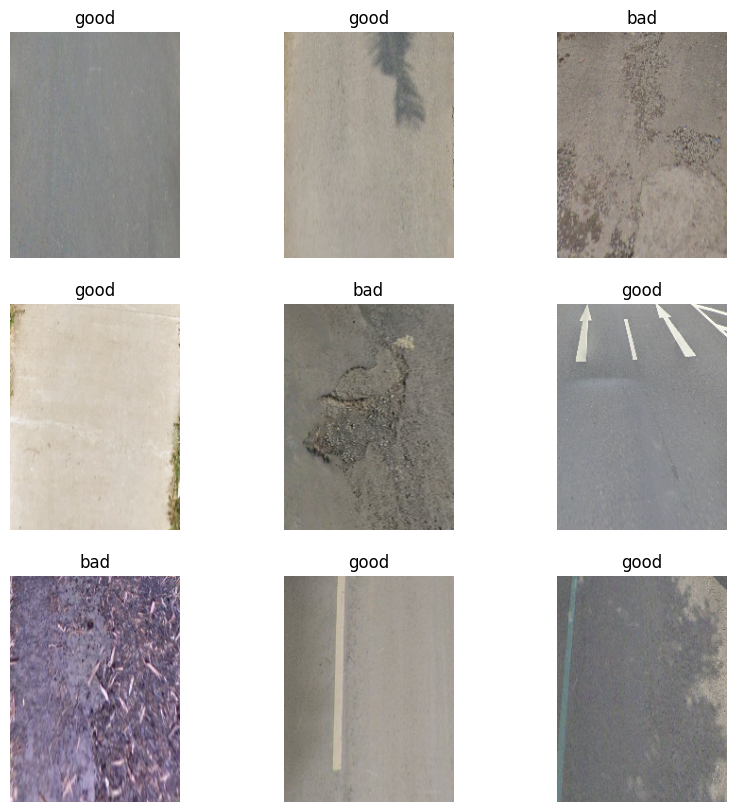

In [138]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Data augmentation untuk mencegah overfitting pada model

In [139]:
data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal", input_shape=(image_height, image_width, 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
])

Membuat model klasifikasi

In [140]:
num_classes = 2
model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
    layers.Conv2D(16, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)    
])

In [141]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_13 (Sequential)  (None, 240, 180, 3)       0         
                                                                 
 rescaling_11 (Rescaling)    (None, 240, 180, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 240, 180, 16)      448       
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 120, 90, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 120, 90, 32)       4640      
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 60, 45, 32)        0         
 ng2D)                                               

Compile menggunakan optimizer Adam

In [142]:
model.compile(optimizer='Adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

Lakukan training model dengan epoch 20

In [143]:
epochs=20
history=model.fit(train_ds, validation_data=validation_ds, epochs=epochs)

Epoch 1/20
4/4 [==============================] - 27s 4s/step - loss: 1.5523 - accuracy: 0.4554 - val_loss: 0.7793 - val_accuracy: 0.4600
Epoch 2/20
4/4 [==============================] - 24s 5s/step - loss: 0.7502 - accuracy: 0.4257 - val_loss: 0.6909 - val_accuracy: 0.4600
Epoch 3/20
4/4 [==============================] - 18s 4s/step - loss: 0.6985 - accuracy: 0.4653 - val_loss: 0.6882 - val_accuracy: 0.5400
Epoch 4/20
4/4 [==============================] - 21s 5s/step - loss: 0.6901 - accuracy: 0.5743 - val_loss: 0.6963 - val_accuracy: 0.5400
Epoch 5/20
4/4 [==============================] - 20s 4s/step - loss: 0.6873 - accuracy: 0.5743 - val_loss: 0.6803 - val_accuracy: 0.6400
Epoch 6/20
4/4 [==============================] - 19s 4s/step - loss: 0.6776 - accuracy: 0.6188 - val_loss: 0.6738 - val_accuracy: 0.5400
Epoch 7/20
4/4 [==============================] - 22s 5s/step - loss: 0.6658 - accuracy: 0.6287 - val_loss: 0.7171 - val_accuracy: 0.4600
Epoch 8/20
4/4 [==================

Lihat hasil dari training model lalu lakukan evaluasi dari hasil tersebut.

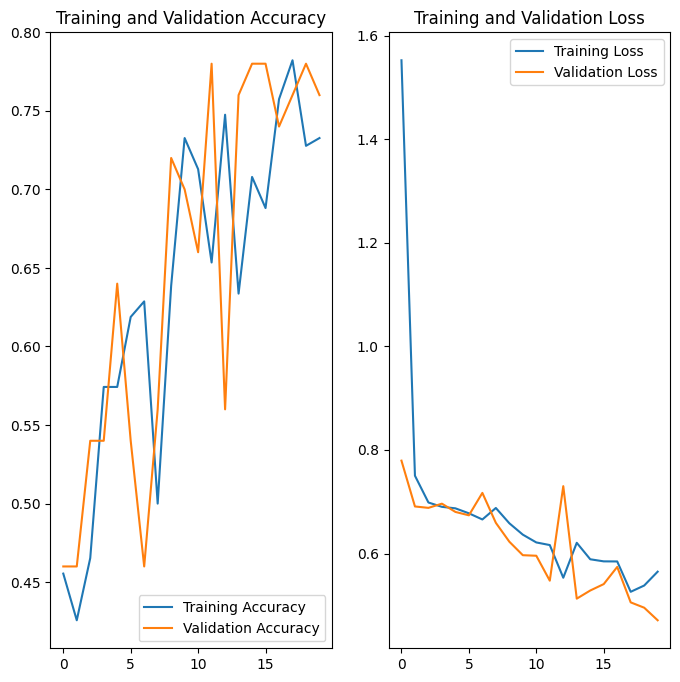

In [144]:
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

Lakukan testing

1/1 [==============================] - 0s 95ms/step


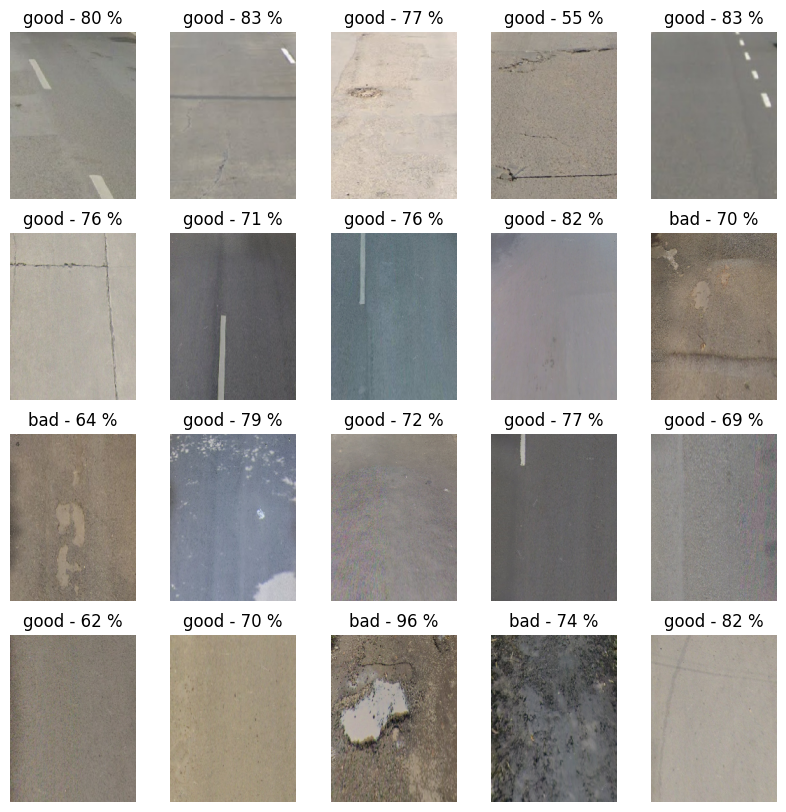

In [145]:
test_dir = pathlib.Path('Test')
road_paths = list(test_dir.glob('*.png'))

plt.figure(figsize=(10, 10))

for i, road_path in enumerate(road_paths):
    road_img = keras.preprocessing.image.load_img(road_path, target_size=(240, 180))
    img_arr = keras.preprocessing.image.img_to_array(road_img)
    img_arr = tf.expand_dims(img_arr, 0)
    
    predictions = model.predict(img_arr)
    
    score = tf.nn.softmax(predictions[0])
    percent = int(round(100*np.max(score), 0))
    title = "{} - {} %".format(class_names[np.argmax(score)], percent)
    
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(road_img)
    plt.title(title)
    plt.axis("off")

Coba testing dengan gambar jalan yang rusak parah

1/1 [==============================] - 0s 157ms/step
This image most likely belongs to bad with a 99.99 percent confidence.


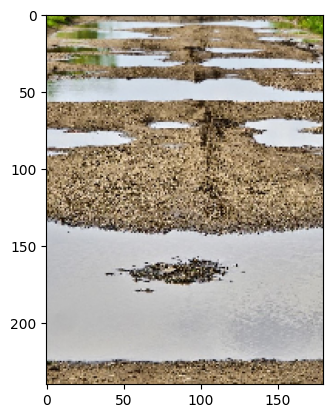

In [167]:
img = tf.keras.utils.load_img(
   "Test_Other//lampung.jpg", target_size=(image_height, image_width)
)

plt.imshow(img)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
   "This image most likely belongs to {} with a {:.2f} percent confidence."
   .format(class_names[np.argmax(score)], 100 * np.max(score))
)
